In [ ]:
!cp /content/drive/MyDrive/dataset/leftImg8bit_trainvaltest.zip /content/
!unzip /content/leftImg8bit_trainvaltest.zip -d /content/



Streaming output truncated to the last 5000 lines.
 extracting: /content/leftImg8bit/train/jena/jena_000074_000019_leftImg8bit.png  
 extracting: /content/leftImg8bit/train/jena/jena_000040_000019_leftImg8bit.png  
 extracting: /content/leftImg8bit/train/jena/jena_000020_000019_leftImg8bit.png  
 extracting: /content/leftImg8bit/train/jena/jena_000030_000019_leftImg8bit.png  
 extracting: /content/leftImg8bit/train/jena/jena_000005_000019_leftImg8bit.png  
 extracting: /content/leftImg8bit/train/jena/jena_000059_000019_leftImg8bit.png  
 extracting: /content/leftImg8bit/train/jena/jena_000100_000019_leftImg8bit.png  
 extracting: /content/leftImg8bit/train/jena/jena_000034_000019_leftImg8bit.png  
 extracting: /content/leftImg8bit/train/jena/jena_000089_000019_leftImg8bit.png  
 extracting: /content/leftImg8bit/train/jena/jena_000104_000019_leftImg8bit.png  
 extracting: /content/leftImg8bit/train/jena/jena_000107_000019_leftImg8bit.png  
 extracting: /content/leftImg8bit/train/jena/je

In [ ]:
!pip install opencv-python matplotlib


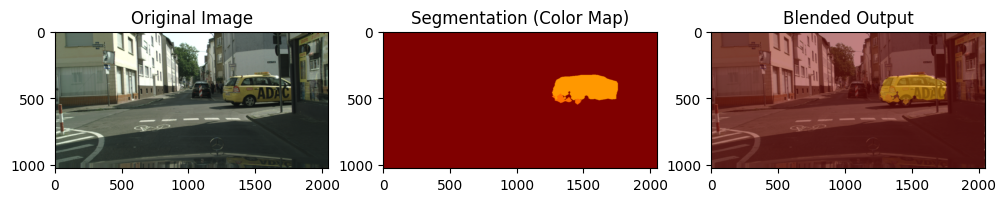

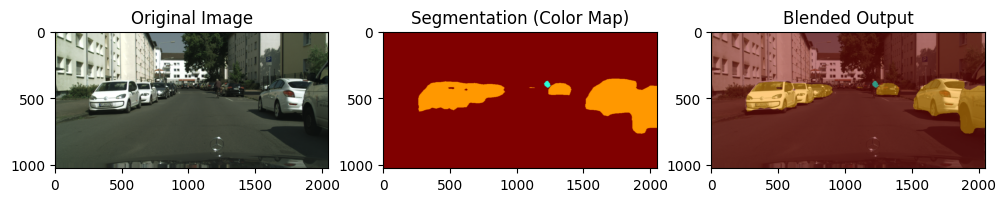

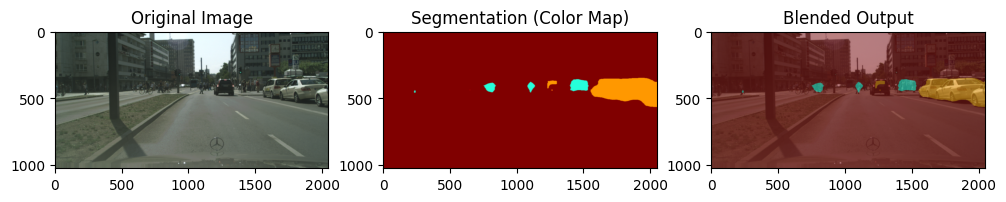

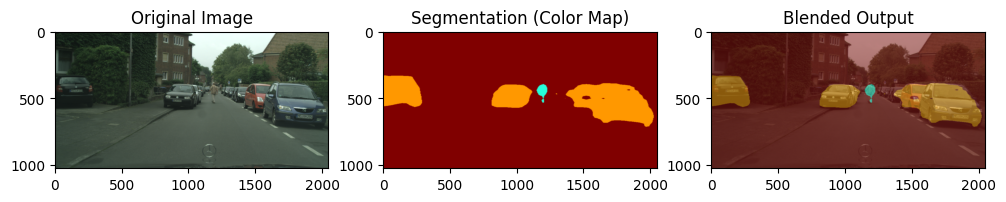

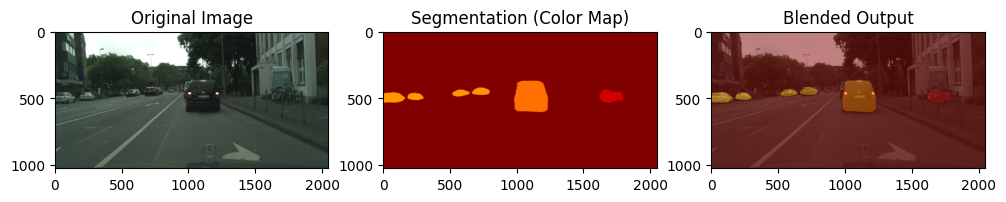

In [18]:
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt
import cv2
import os

# Load pre-trained DeepLabV3 model
model = deeplabv3_resnet101(pretrained=True).eval()

# Preprocess function for input images
preprocess = T.Compose([
    T.ToPILImage(),
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Directories containing the images and labels
image_dir = '/content/dataset/leftImg8bit/val/frankfurt'
label_dir = '/content/dataset/gtFine/val/frankfurt'

# Get the list of image files
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')])
label_paths = sorted([os.path.join(label_dir, fname) for fname in os.listdir(label_dir) if 'labelIds' in fname])

# Load and preprocess images
input_batch = []
original_images = []

for image_path in image_paths[:20]:  # Limit to 20 images
    # Read the image
    image = cv2.imread(image_path)
    original_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Store original image for later

    # Preprocess the image
    input_tensor = preprocess(image)
    input_batch.append(input_tensor)

# Stack all preprocessed images into a batch
input_batch = torch.stack(input_batch)

# Perform segmentation on the batch
with torch.no_grad():
    output = model(input_batch)['out']

# Visualize the results
for i in range(len(output)):
    output_predictions = output[i].argmax(0).byte().cpu().numpy()

    # Apply a color map to the segmented output
    color_map = cv2.applyColorMap(output_predictions * 10, cv2.COLORMAP_JET)

    # Resize color_map to match the original image size
    color_map_resized = cv2.resize(color_map, (original_images[i].shape[1], original_images[i].shape[0]))

    # Blend original image with the color map
    blended = cv2.addWeighted(original_images[i], 0.5, color_map_resized, 0.5, 0)

    # Display the results for each image
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_images[i])
    plt.title('Original Image')

    # Segmentation output (color map)
    plt.subplot(1, 3, 2)
    plt.imshow(color_map_resized)
    plt.title('Segmentation (Color Map)')

    # Blended output
    plt.subplot(1, 3, 3)
    plt.imshow(blended)
    plt.title('Blended Output')

    plt.show()


# New Section